In [1]:
import sys
sys.path.append('../')

In [2]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [3]:
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date
from utils.loss_functions import return_loss, sharpe_loss, return_loss_dummy, sharpe_loss_dummy

In [4]:
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 8}) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
RAD_DATA_PATH = '../data/clc/rad/'
FED_DATA_PATH = '../data/FEDFUNDS.csv'

In [6]:
clc = load_clc_db_records(RAD_DATA_PATH, FED_DATA_PATH)

In [7]:
assets_to_use = ['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ']
exclude_assets = ['FF', 'EC', 'TU', 'SS']
assets_to_use = list(set(assets_to_use) - set(exclude_assets))

temp_clc = {}
for asset, df in clc.items():
    if asset in assets_to_use:
        temp_clc[asset] = df
clc = temp_clc

In [8]:
clc = construct_features_batch(clc)

../utils/features.py:52: RuntimeWarning: invalid value encountered in log
  df['Sigma_Norm'] = np.log(df['Sigma'] / df['Sigma'].rolling(181).mean())


In [149]:
df = merge_asset_data(clc, create_time_asset_index=True)
df.dropna(inplace=True)

In [150]:
from datetime import datetime
# min_date = df.groupby('Asset_Col').Date_Col.min()
# max_date = df.groupby('Asset_Col').Date_Col.max()
# data_counts = df.groupby('Asset_Col').Date_Col.count()
# mask = ((max_date >= datetime(2020, 1, 1)) & (min_date <= datetime(1990, 1, 1)) & (data_counts > 4000))
# df = df[df.Asset_Col.isin(data_counts.index[mask].values)]
# df = df[df.Asset_Col == 'SP']

In [151]:
date_breakpoints = [datetime(1990, 1, 1), datetime(1995, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]
# date_breakpoints = [datetime(1990, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]
data_set = split_by_date(df, date_breakpoints)

In [29]:
data_set[0].head()

Open   High    Low  Settle  Volume  Open_Interest  \
Asset Date                                                             
AN    1990-01-02  43.46  43.51  43.30   43.30     125           2576   
      1990-01-03  43.23  43.31  43.12   43.14    1495           3232   
      1990-01-04  43.33  43.63  43.29   43.56     932           3145   
      1990-01-05  43.32  43.45  43.28   43.28     272           2567   
      1990-01-08  43.45  43.46  43.34   43.40     177           2456   

                  Short_Rate_Daily  Short_Rate_Annual  Returns_Daily  \
Asset Date                                                             
AN    1990-01-02          0.000322             0.0845      -0.007564   
      1990-01-03          0.000322             0.0845      -0.003695   
      1990-01-04          0.000322             0.0845       0.009736   
      1990-01-05          0.000322             0.0845      -0.006428   
      1990-01-08          0.000322             0.0845       0.002773   

                  Next_Returns_Daily  ...  MACD_16_48  MACD_32_96  \
Asset Date                            ...                           
AN    1990-01-02           -0.003695  ...    1.396906    1.486063   
      1990-01-03            0.009736  ...    1.305883    1.473971   
      1990-01-04           -0.006428  ...    1.298588    1.478928   
      1990-01-05            0.002773  ...    1.238528    1.472797   
      1990-01-08            0.001152  ...    1.205557    1.471873   

                  Binary_MACD_8_24  Binary_MACD_16_48  Binary_MACD_32_96  \
Asset Date                                                                 
AN    1990-01-02              True               True               True   
      1990-01-03              True               True               True   
      1990-01-04              True               True               True   
      1990-01-05              True               True               True   
      1990-01-08              True               True               True   

                  Sigma_Norm  Next_Returns_Weekly  Excess_Returns_Daily  \
Asset Date                                                                
AN    1990-01-02   -0.382612             0.003464             -0.007886   
      1990-01-03   -0.384980             0.010895             -0.004017   
      1990-01-04   -0.344513             0.006428              0.009414   
      1990-01-05   -0.328893             0.013863             -0.006750   
      1990-01-08   -0.339329             0.009447              0.002451   

                  Asset_Col   Date_Col  
Asset Date                              
AN    1990-01-02         AN 1990-01-02  
      1990-01-03         AN 1990-01-03  
      1990-01-04         AN 1990-01-04  
      1990-01-05         AN 1990-01-05  
      1990-01-08         AN 1990-01-08  

[5 rows x 27 columns]

In [72]:
epochs = 100
batch_size = 2 ** 11
feature_labels = [
   'Norm_Returns_Daily', 'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
   'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
   'MACD_16_48', 'MACD_32_96','Sigma_Norm'
]#'Binary_MACD_8_24', 'Binary_MACD_16_48', 'Binary_MACD_32_96'
target_labels = ['Next_Returns_Daily', 'Sigma']
# feature_labels = [
#     'Norm_Returns_Monthly',
#    'Binary_MACD_8_24', 
# #     'Binary_MACD_16_48', 'Binary_MACD_32_96',
#     'Sigma_Norm'
# ]

In [77]:
def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(input_shape, activation='relu', kernel_initializer='normal', input_shape=(input_shape,)))
    model.add(Dropout(0.3))
#     model.add(Dense(7, activation='relu', kernel_initializer='normal', bias_initializer='normal'))
#     model.add(Dropout(0.3))
    model.add(Dense(5, activation='relu', kernel_initializer='normal', bias_initializer='normal'))
    model.add(Dropout(0.25))
#     model.add(Dense(3, activation='relu', kernel_initializer='normal', bias_initializer='normal'))
#     model.add(Dropout(0.2))
    model.add(Dense(1, activation='tanh', kernel_initializer='normal', bias_initializer='normal'))
    return model

In [152]:
import keras.backend as K
def my_sharpe_loss(target_data, size_prediction, sigma_tgt=0.15):
    """Sharpe ratio inspired loss function."""

    # load parameters
#     size_prediction = K.sign(size_prediction)
    next_period_return = K.reshape(target_data[:, 0], (-1, 1))
    sigma_t = K.reshape(target_data[:, 1], (-1, 1))

    # calc sharpe
    ret = size_prediction * sigma_tgt * next_period_return / (np.sqrt(252) * sigma_t)
    mean_ret = K.mean(ret)
    mean_ret2 = K.mean(ret ** 2)
    sharpe = np.sqrt(252) * mean_ret / K.sqrt(mean_ret2 - (mean_ret ** 2))

    return -sharpe

In [153]:
from keras import optimizers

model = create_mlp(len(feature_labels))
model.summary()

# opti = optimizers.Adagrad()
# opti = optimizers.SGD(momentum=0.9, nesterov=True)
opti = optimizers.Adam(lr=0.008, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(
    loss=my_sharpe_loss,
    optimizer=opti
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_17 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 50        
_________________________________________________________________
dropout_18 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [154]:
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

temp_series = pd.DataFrame()
for data_idx, data_series in enumerate(data_set):
    
    epoch_start = data_series.Date_Col.min()
    epoch_start = data_series.Date_Col.max()

    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    val_series = data_set[data_idx + 1]
#     val_series = pd.concat(data_set[1:])
    
    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series
    
    # construct features and targets
    scaler = StandardScaler()
    scaler.fit(data_series[feature_labels].values)
    X = scaler.transform(data_series[feature_labels].values)
    X = data_series[feature_labels].values
    y = data_series[target_labels].values
    X_val = scaler.transform(val_series[feature_labels].values)
    y_val = val_series[target_labels].values

    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('../models/overnight_best_mlp_{}.hdf5'.format(epoch_start), save_best_only=True, monitor='val_loss', mode='min')
    
    history = model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[mcp_save, earlyStopping]
    )
    break
    
    # backtest

Train on 56204 samples, validate on 60386 samples
Epoch 1/100
56204/56204 [==============================] - 1s 20us/step - loss: -0.2414 - val_loss: -0.4906
Epoch 2/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.6455 - val_loss: -0.6279
Epoch 3/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.7034 - val_loss: -0.7167
Epoch 4/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.7832 - val_loss: -0.7173
Epoch 5/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.7297 - val_loss: -0.7406
Epoch 6/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.7864 - val_loss: -0.6823
Epoch 7/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.8443 - val_loss: -0.7216
Epoch 8/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.8822 - val_loss: -0.7386
Epoch 9/100
56204/56204 [==============================] - 0s 4us/step - loss: -0.7915 - val_

In [177]:
from scipy import stats
def my_calc_single_asset_backtest(daily_return_series, excess_return_series, weights, target_vol=None):
    """Backtest a single asset trading strategy."""

    # construct backtest dataframe
    daily_return_series = daily_return_series.rename('Returns')
    weights = weights.rename('Weights')
    excess_return_series = excess_return_series.rename('Excess_Returns')
    backtest_series = pd.concat([daily_return_series, excess_return_series, weights], axis=1)
    backtest_series.Weights.ffill(inplace=True)
    backtest_series.dropna(inplace=True)
    num_data_per_year = backtest_series.Returns.resample('Y').count().mode().values[-1]
    num_data_total = backtest_series.shape[0]
    if target_vol is not None:
        backtest_series['Strategy_Returns'] = backtest_series['Weights'] * backtest_series['Returns']
        backtest_series['Weights'] = backtest_series['Weights'] * target_vol / (np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year))
    backtest_series['Strategy_Returns'] = backtest_series['Weights'] * backtest_series['Returns']
    backtest_series['Strategy_Excess_Returns'] = backtest_series['Weights'] * backtest_series['Excess_Returns']

    # basic return stats
    mean_ret_annual = ((1 + backtest_series['Strategy_Returns']).prod()) ** (num_data_per_year / num_data_total) - 1
    mean_exc_ret_annual = ((1 + backtest_series['Strategy_Excess_Returns']).prod()) ** (
            num_data_per_year / num_data_total) - 1
    vola_annual = np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year)
    sharpe = mean_exc_ret_annual / vola_annual

    # drawdown stats
    position = (1 + backtest_series['Strategy_Returns']).cumprod()
    cummax_position = position.cummax()
    drawdown = position - cummax_position
    is_in_drawdown = drawdown < 0
    longest_drawdown_duration = (~is_in_drawdown).cumsum()[is_in_drawdown].value_counts().max() / num_data_per_year
    max_drawdown = (drawdown / cummax_position).min()

    results = pd.Series({
        'E[Return]': mean_ret_annual,
        'E[Excess Return]': mean_exc_ret_annual,
        'Std[Return]': vola_annual,
        'Skew[Return]': stats.skew(backtest_series['Strategy_Returns']),
        'Exc.Kurtosis[Return]': stats.kurtosis(backtest_series['Strategy_Returns']),
        'Sharpe': sharpe,
        'Max_Drawdown': max_drawdown,
        'Max_Drawdown_Duration (Years)': longest_drawdown_duration
    })

    return results

In [179]:
from utils.backtest import calc_single_asset_backtest
backtest_results = {}
for asset, sub_df in df.groupby('Asset_Col'):
    sub_df = sub_df.set_index('Date_Col', drop=False)
    sub_df = sub_df['1995-1-1':'2000-1-1']
    signal = pd.Series(model.predict(sub_df[feature_labels].values).reshape(-1), index=sub_df['Date_Col'])
#     signal = 0.15 * signal / signal.ewm(span=21).std()
    positions = signal * 0.15 / sub_df['Sigma']
    positions = positions.ewm(span=21).mean()
    positions = positions.shift(1)
#     positions = positions.resample('M').last()
#     print(positions)
    backtest_results[asset] = my_calc_single_asset_backtest(sub_df.Returns_Daily, sub_df.Excess_Returns_Daily, positions, 0.15)
    positions
#     break

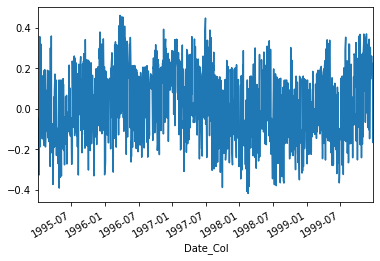

In [180]:
signal.plot()

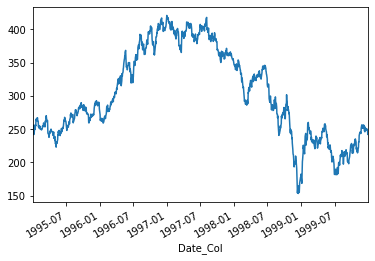

In [181]:
sub_df.Settle.plot()

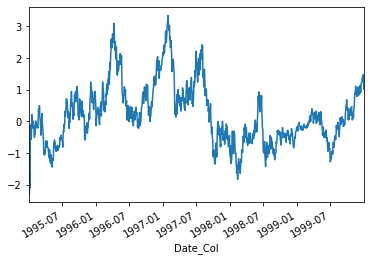

In [182]:
positions.plot()

In [183]:
backtest_df = pd.DataFrame(backtest_results).T

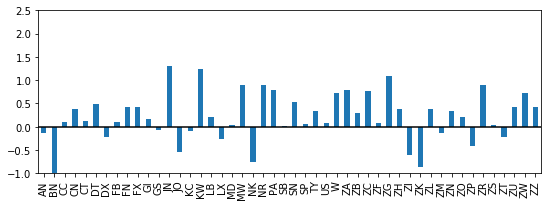

In [184]:
plt.figure(figsize=(9, 3))
backtest_df.Sharpe.plot('bar')
plt.ylim(-1, 2.5)
plt.hlines(0, -10, 90)

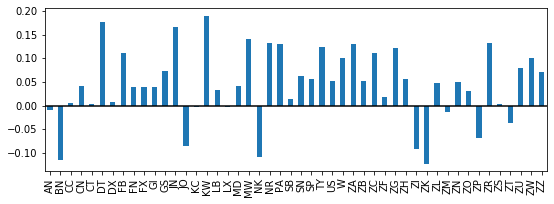

In [185]:
plt.figure(figsize=(9, 3))
backtest_df['E[Return]'].plot('bar')
# plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)

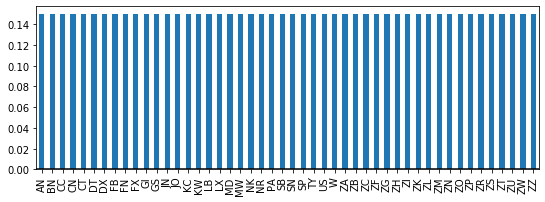

In [186]:
plt.figure(figsize=(9, 3))
backtest_df['Std[Return]'].plot('bar')
# plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)

In [267]:
np.random.choice(X.shape[0], 100, replace=False)

array([46176, 11656, 41925,  1100, 21945, 40042, 32517, 35676, 24429,
       42726, 24214,  4131, 25449, 48462,  2585, 30098, 38625, 43722,
       45642, 56698, 11135, 13487, 32835,   313, 27142, 31264, 17917,
       54581, 41191,  4480, 29369,  8911, 41843, 20955, 47198, 47946,
       14737, 59477, 55741, 57361, 39521, 17783, 45462, 33331, 37293,
       44070, 15907, 44985, 15491, 34009, 18047, 39155,   729, 36524,
       40104, 41269, 10259, 26060, 21101, 16209, 36371, 10524, 13078,
       41169,  7149,  9190,   740, 56910,  4242, 17017, 19491, 46105,
       36015, 19234, 57194, 26531, 14480,  9478, 39809, 44868, 54421,
       19640, 50591, 47201, 58243, 15264, 26459, 53003, 12060, 41309,
       35668, 35703, 46269, 55819, 24735, 27983, 11727, 11208, 53347,
       20828])

In [204]:
shap.initjs()

In [239]:
import shap

shap_X = pd.DataFrame(X, columns=feature_labels)
shap_X_val = pd.DataFrame(X_val, columns=feature_labels)

background = shap_X.iloc[np.random.choice(shap_X.shape[0], 1000, replace=False), :]
explainer = shap.DeepExplainer(model, background)


In [240]:
shap_values = explainer.shap_values(background.values)

# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], background[0,:], feature_names=feature_labels)

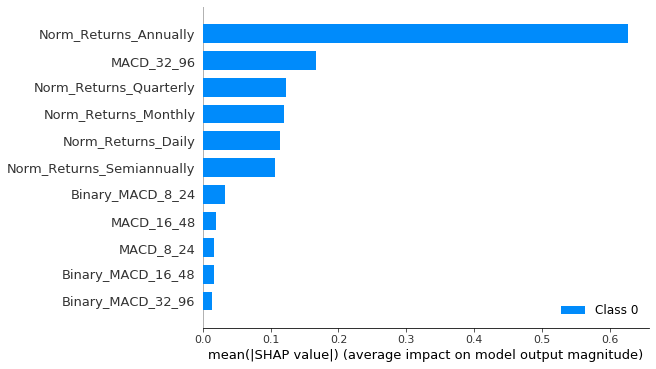

In [252]:
shap.summary_plot(shap_values, shap_X_val)

In [243]:
feature_labels

['Norm_Returns_Daily',
 'Norm_Returns_Monthly',
 'Norm_Returns_Quarterly',
 'Norm_Returns_Semiannually',
 'Norm_Returns_Annually',
 'MACD_8_24',
 'MACD_16_48',
 'MACD_32_96',
 'Binary_MACD_8_24',
 'Binary_MACD_16_48',
 'Binary_MACD_32_96']

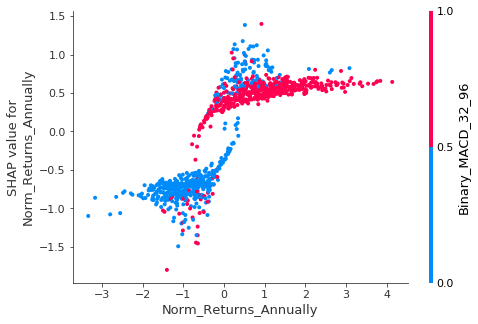

In [257]:
shap.dependence_plot('Norm_Returns_Annually', shap_values[0], background, interaction_index='Binary_MACD_32_96')

In [69]:
preds = model.predict(X)

In [70]:
preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

(array([26872.,   130.,    87.,    70.,    66.,    67.,    77.,    96.,
          110., 32811.]),
 array([-0.98925346, -0.79032815, -0.59140277, -0.39247742, -0.19355208,
         0.00537327,  0.20429862,  0.40322396,  0.6021493 ,  0.8010746 ,
         1.        ], dtype=float32),
 <a list of 10 Patch objects>)

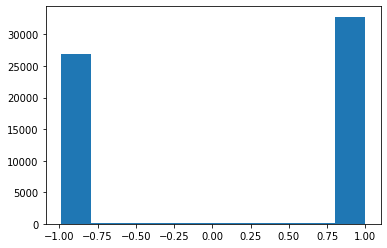

In [71]:
plt.hist(preds)

In [45]:

temp_series = pd.DataFrame()
for data_idx, data_series in enumerate(data_set):
    
    epoch_start = data_series.Date_Col.min()
    
    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    val_series = data_set[data_idx + 1]
    
    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series
    
    # construct features and targets
    X = data_series[feature_labels].values
    y = data_series[['Next_Returns_Daily', 'Sigma']].values
    X_val = val_series[feature_labels].values
    y_val = val_series[['Next_Returns_Daily', 'Sigma']].values
    
    print(X.shape, y.shape)
    print(sharpe_loss_dummy(y_val, 1.0 * np.ones(X_val.shape[0])))
    

(65394, 3) (65394, 2)
[-0.00897073  0.00345981 -0.00415321 ...  0.02146357  0.01383982
  0.00391931] [1.95528651 1.86343002 1.88443505 ... 0.70574862 0.69249298 0.6957283 ] [1. 1. 1. ... 1. 1. 1.]
-0.25967160118314275
(130484, 3) (130484, 2)
[-0.01927728  0.00071403 -0.00626512 ...  0.00305439 -0.00038654
  0.00380847] [1.24170319 1.13483732 1.15388031 ... 0.58666158 0.59634771 0.60629469] [1. 1. 1. ... 1. 1. 1.]
-0.1893210355486796
(195952, 3) (195952, 2)
[ 0.00013454  0.01030592 -0.00226621 ... -0.00767471  0.00031285
  0.00122959] [1.00995145 1.02687683 1.02537761 ... 0.79335091 0.80353713 0.81647736] [1. 1. 1. ... 1. 1. 1.]
-0.05302020570314409
(261577, 3) (261577, 2)
[-0.00267261  0.00203692 -0.0033121  ...  0.01721576 -0.00524003
  0.0017412 ] [1.79970536 1.82814296 1.84504957 ... 0.50805351 0.50892741 0.5167817 ] [1. 1. 1. ... 1. 1. 1.]
0.05248917051436436


In [134]:
df.Asset_Col.unique()

array(['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ'], dtype=object)

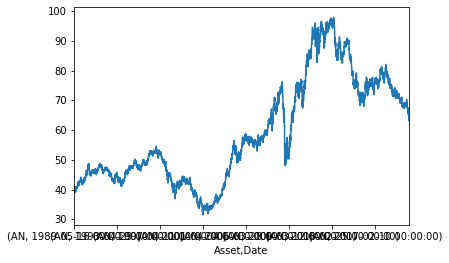

In [135]:
df[df.Asset_Col == 'AN'].Settle.plot()

In [47]:
def sharpe_loss_dummy(target_data, size_prediction, sigma_tgt=0.15):
    """Sharpe ratio inspired loss function."""

    # load parameters
    next_period_return = target_data[:, 0]
    sigma_t = target_data[:, 1]

    # calc sharpe
#     print(next_period_return, sigma_tgt / (np.sqrt(252) * sigma_t), size_prediction)
    ret = size_prediction * sigma_tgt * next_period_return / (np.sqrt(252) * sigma_t)
    mean_ret = np.mean(ret)
    mean_ret2 = np.mean(ret ** 2)
    sharpe = ((1 + mean_ret)**252 - 1) / np.sqrt(252 * (mean_ret2 - (mean_ret ** 2)))

    print(mean_ret, np.mean(size_prediction * sigma_tgt / (np.sqrt(252) * sigma_t)), np.sqrt(mean_ret2 - (mean_ret ** 2)), mean_ret2, mean_ret ** 2)
    
    return -sharpe

temp_df = data_set[1]
# temp_df = temp_df[temp_df.Asset_Col == 'SP']

print(sharpe_loss_dummy(temp_df[['Next_Returns_Daily', 'Sigma']].values, 1 * np.ones(temp_df.shape[0])))

0.00015703998295778115 5.3720792060686735 0.00979203634798409 9.590863739648897e-05 2.4661556247380194e-08
-0.25967160118314275


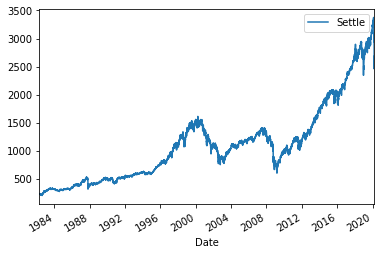

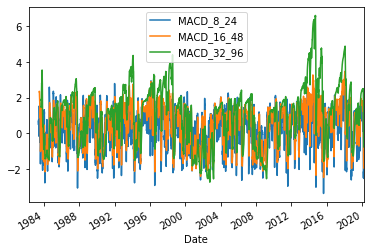

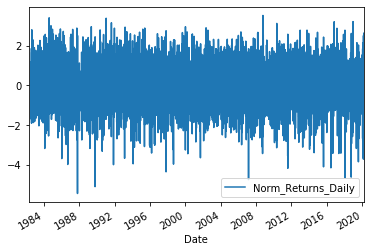

In [67]:
df.plot(x='Date', y=['Settle'])
plt.show()
df.plot(x='Date', y=['MACD_8_24', 'MACD_16_48', 'MACD_32_96'])
plt.show()
df.plot(x='Date', y=['Norm_Returns_Daily'])


In [31]:
0.007239 * np.sqrt(252)

0.11491556244477943